<a href="https://colab.research.google.com/github/ryomado/waste-sorting/blob/master/waste_sorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import os
#import zipfile as zf
import shutil
import re
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**Giải nén dataset**

---



In [0]:
!unzip -q "/content/gdrive/My Drive/dataset-resized.zip"

Có 6 thư mục con trong dataset-resized:

In [4]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['trash', 'paper', 'glass', '.DS_Store', 'metal', 'plastic', 'cardboard']

**Sắp sếp**

---


Chia hình ảnh thành các thư mục:


*   Train: 50%
*   Validation: 25%
*   Test: 25%







In [0]:
# XÂY DỰNG HÀM CẦN THIẾT:

# chia số lượng ảnh cho các mục(train, valid, test) với cách lấy mẫu ngẫu nhiên
  # input: folder_path
  # output: train, valid and test indices
def split_indices(folder, seed1, seed2):
  n = len(os.listdir(folder))
  full_set = list(range(1, n+1))

  # train
  random.seed(seed1)
  train = random.sample(list(range(1, n+1)), int(.5*n))

  # temp
  remain = list(set(full_set)-set(train))

  # tách phần còn lại thành validation & test
  random.seed(seed2)
  valid = random.sample(remain, int(.5*len(remain)))
  test = list(set(remain)-set(valid))

  return(train, valid, test)

# trả về tên của một loại rác cụ thể, được chỉ định
  # input: waste category and indices
  # output: file name
def get_names(waste_type, indices):
  file_names = [waste_type+str(i)+".jpg" for i in indices]
  return (file_names)

# di chuyển nhóm file sang thư mục khác
  # input: list of source files and destination folder
  # no output
def move_files(source_files, destination_folder):
  for file in source_files:
    shutil.move(file, destination_folder)

In [0]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train', 'valid']
waste_types = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

## create destinations folder for data subset and waste type
for subset in subsets:
  for waste_type in waste_types:
    folder = os.path.join('data', subset, waste_type)
    if not os.path.exists(folder):
      os.makedirs(folder)

if not os.path.exists(os.path.join('data', 'test')):
  os.makedirs(os.path.join('data', 'test'))

## move files to destination folders each waste type
for waste_type in waste_types:
  source_folder = os.path.join('dataset-resized', waste_type)
  train_ind, valid_ind, test_ind = split_indices(source_folder, 1, 1)

  ## move source files to train
  train_names = get_names(waste_type, train_ind)
  train_source_files = [os.path.join(source_folder, name) for name in train_names]
  train_dest = "data/train/"+waste_type
  move_files(train_source_files, train_dest)

  ## move source files to valid
  valid_names = get_names(waste_type, valid_ind)
  valid_source_files = [os.path.join(source_folder, name) for name in valid_names]
  valid_dest = "data/valid/"+waste_type
  move_files(valid_source_files, valid_dest)

  ## move source files to test
  test_names = get_names(waste_type, test_ind)
  test_source_files = [os.path.join(source_folder, name) for name in test_names]
  ## I use data/test here because the images can be mixed up
  move_files(test_source_files, "data/test")

Now that the data's organized, we get to the model training

In [7]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True)
data = ImageDataBunch.from_folder(path, test="test", ds_tfms=tfms, bs=16)
## We can change size of bs,the batch(bs) is how many image we will trai at a time.

In [10]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [12]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


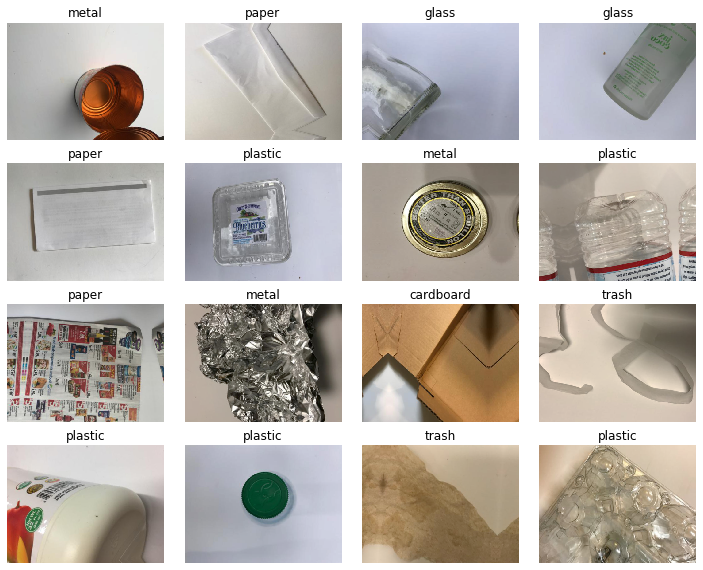

In [21]:
## example of data
data.show_batch(rows=4, figsize=(10,8))

**Model training**



---



In [22]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 185MB/s]


**What is resnet34?**



In [23]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Finding a learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


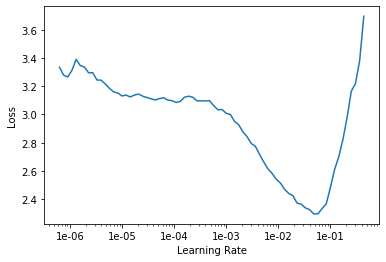

In [25]:
#learn.lr_find(start_lr=1e-6, end_lr=1e1)
learn.lr_find()
learn.recorder.plot()

Training

In [0]:
learn.fit_one_cycle(20, max_lr=5.13e-03)

In [0]:
learn.save("resnet34", return_path=True)

Xem những hình ảnh được phân loại không chính xác:

In [0]:
interp = ClassificationInterpretationrpretation.from_learner(learn)
losses, idxs = interp.top_losses()

In [0]:
interp.plot_top_losses(9, figsize=(15, 11))

In [0]:
doc(interp.plot_top.losses)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [0]:
interp.most_confused(min_val=2)